In [1]:
import json


data = []

with open('../data/bc5cdr/train.json', 'rt') as f:
    for line in f:
        example = json.loads(line)
        sentences = example['sentences']
        example['sentence_lens'] = [len(sentence) for sentence in sentences]
        example['tokens'] = [token for sent in sentences for token in sent]
        example['paragraph_len'] = len(example['tokens'])
        data.append(example)

In [2]:
from matplotlib import pyplot

pyplot.hist([line['paragraph_len'] for line in data])

(array([26., 59., 64., 59., 79., 56., 57., 51., 75., 22.]),
 array([ 13. ,  45.4,  77.8, 110.2, 142.6, 175. , 207.4, 239.8, 272.2,
        304.6, 337. ]),
 <a list of 10 Patch objects>)

In [3]:
from transformers import AutoTokenizer

def _wordpiece_tokenize_input(tokens):
    bert_tokenizer = AutoTokenizer.from_pretrained('../embeddings/scibert_scivocab_uncased')
    word_piece_tokens = []
    end_offsets = []
    start_offsets = []
    cumulative = 0
    for token in tokens:
        token = token.lower()
        word_pieces = bert_tokenizer.wordpiece_tokenizer.tokenize(token)
        start_offsets.append(cumulative + 1)
        cumulative += len(word_pieces)
        end_offsets.append(cumulative)
        word_piece_tokens.extend(word_pieces)

    wordpieces = ["[CLS]"] + word_piece_tokens + ["[SEP]"]

    return wordpieces, end_offsets, start_offsets

def _convert_span_to_wordpiece_span(ner_spans, start_offsets, end_offsets):
    result = []
    for start, end, tag in ner_spans:
        start = start_offsets[start]
        end = end_offsets[end]
        result.append((start, end, tag))
    return result

/Users/ethan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ethan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ethan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ethan/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework

In [4]:
from tqdm import tqdm

for line in tqdm(data):
    spans = [span for sent in line['ner'] for span in sent]
    wordpieces, end_offsets, start_offsets = _wordpiece_tokenize_input(line['tokens'])
    wp_spans = _convert_span_to_wordpiece_span(spans, start_offsets, end_offsets)
    line['wp_spans'] = wp_spans
    

100%|██████████| 548/548 [00:13<00:00, 39.23it/s]


(array([8.482e+03, 6.720e+02, 7.000e+01, 2.700e+01, 6.000e+00, 6.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ]),
 <a list of 10 Patch objects>)

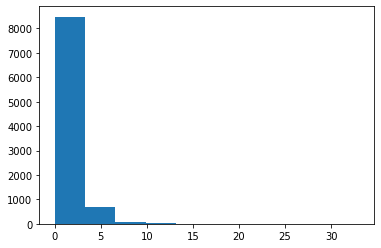

In [5]:
span_lens = [end - start for line in data for start, end, _ in line['wp_spans']]
pyplot.hist(span_lens)

In [10]:
threshold = 6

len([length for length in span_lens if length <= threshold]) / len(span_lens)

0.9874865156418554